# Notebook for Developing Experiments on CovType Data Set

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load Data

In [3]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

<IPython.core.display.Javascript object>

**NEED TO**
 - Check distribution of class labels in each "concept" that I've created...

## Experiments

### Prepare Test Harness

In [4]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

<IPython.core.display.Javascript object>

In [18]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

# 17500
CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 3
)

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [1000, 2000], "clf__max_depth": [3, 5]}

<IPython.core.display.Javascript object>

### Run

In [19]:
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

topline = ToplineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
topline.run()

uncertainty_ks = UncertaintyKSExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks.run()

uncertainty_x2 = UncertaintyX2Experiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2.run()

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
FINAL SHAPE kfold preds: (52500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=52500, minmax=(0.20229688262881906, 0.8876407026836075), mean=0.5726753402660725, variance=0.0347837195811138, skewness=-0.19064670132618763, kurtosis=-1.5880067867286418)
DETECTION STATS: DescribeResult(nobs=52500, minmax=(0.20105213468125951, 0.8871840581352968), mean=0.5721069759051004, variance=0.03451220420852638, skewness=-0.1839110108321391, kurtosis=-1.5885550002078392)
KS Test Result: PASSED | KstestResult(statistic=0.00683809523809531, pvalue=0.17085890424915628)

Dataset index of split end: 157500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
Dataset Split: 2
REFERENCE STATS: DescribeResult(nobs=52500, minmax=(0.20229688262881906, 0.8876407026836075), mean=0.5726753402660725, variance=0.0347837195811138, skewness=-0.19064670132618763, kurtosis=-1.5880067867286418)
DE

<IPython.core.display.Javascript object>

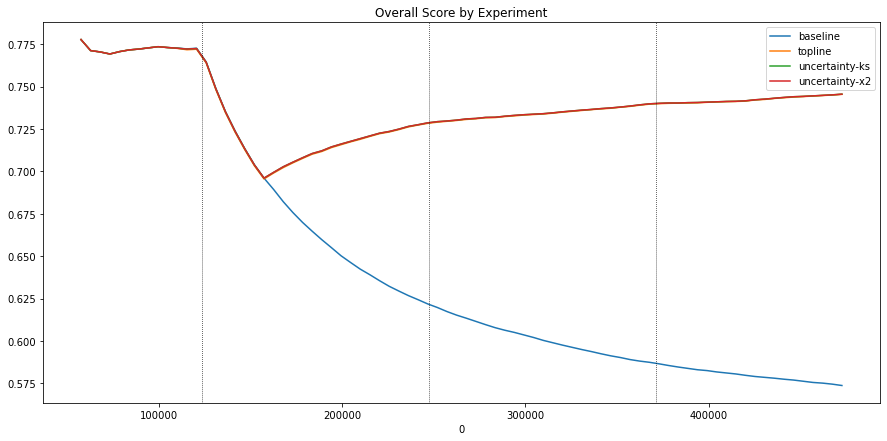

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.1060,21.97
topline,9,0.9543,311.51
uncertainty-ks,8,0.8482,296.32
uncertainty-x2,8,0.8482,289.24


<IPython.core.display.Javascript object>

In [21]:
exps = [baseline, topline, uncertainty_ks, uncertainty_x2]
# exps = [uncertainty_ks]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

### Uncertainty KS Debug

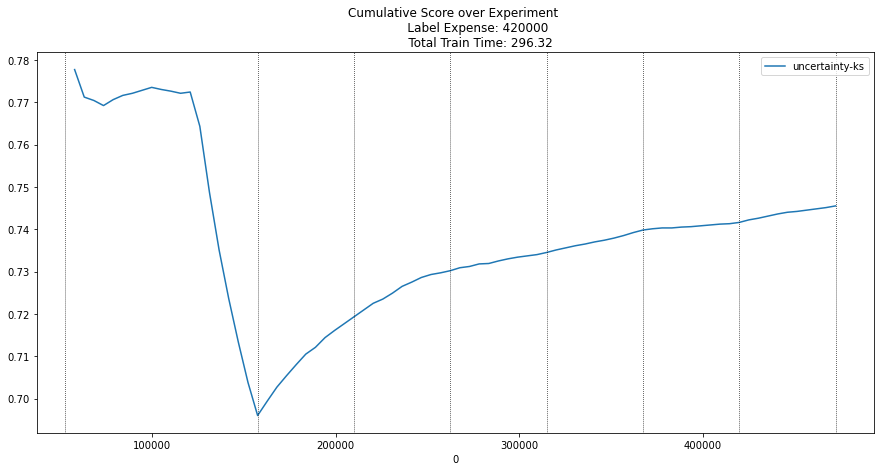

<IPython.core.display.Javascript object>

In [22]:
plot_experiment_error(uncertainty_ks)

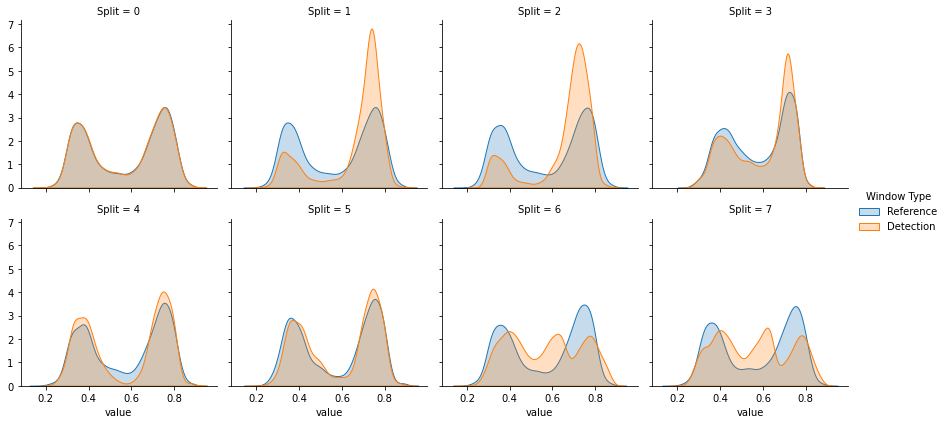

<IPython.core.display.Javascript object>

In [24]:
plot_response_distributions_bysplit(uncertainty_ks)

### Margin Uncertainty Debug

Same Distribution: True
Expected Distribution: [0.9297142857142857, 0.07028571428571428]
Observed Distribution: [0.9271047619047619, 0.0728952380952381]
Percent change in margin: 0.0371
Number in Margin: Before 3690 | After 3827 | Difference -137
Chi-Square Results: Power_divergenceResult(statistic=5.470981722724418, pvalue=0.019334761709699173)

Same Distribution: False
Expected Distribution: [0.9297142857142857, 0.07028571428571428]
Observed Distribution: [0.9683809523809523, 0.031619047619047616]
Percent change in margin: 0.5501
Number in Margin: Before 3690 | After 1660 | Difference 2030
Chi-Square Results: Power_divergenceResult(statistic=1201.202439190956, pvalue=3.3417631347581286e-263)

Same Distribution: False
Expected Distribution: [0.9276190476190476, 0.07238095238095238]
Observed Distribution: [0.9798095238095238, 0.02019047619047619]
Percent change in margin: 0.7211
Number in Margin: Before 3800 | After 1060 | Difference 2740
Chi-Square Results: Power_divergenceResult(stat

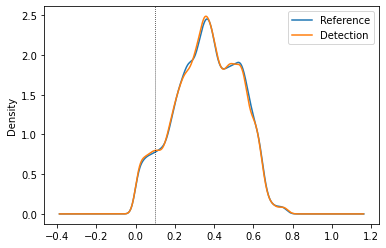

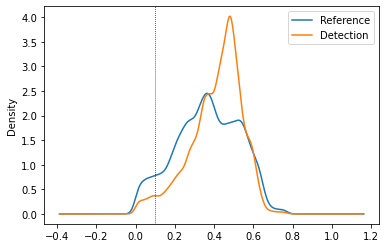

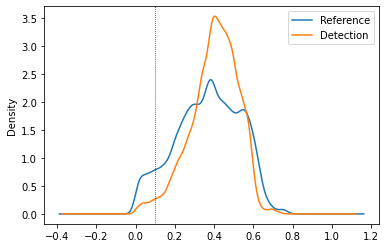

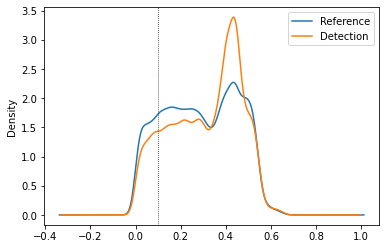

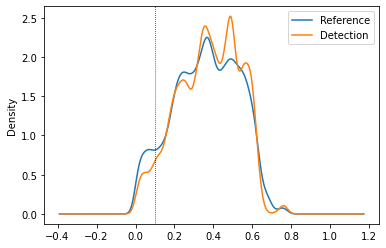

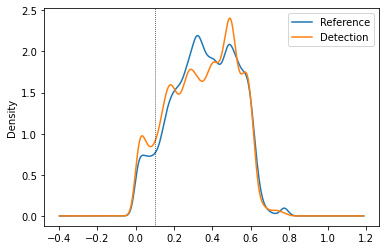

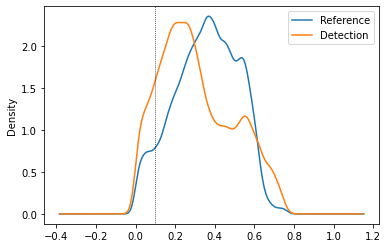

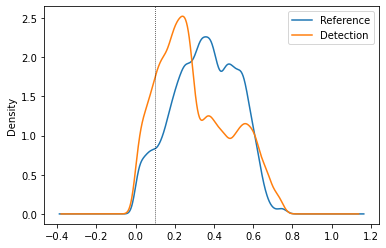

<IPython.core.display.Javascript object>

In [25]:
plot_margin_distributions_bysplit(uncertainty_x2)

## KS Test Deep Dive

### What is minimum reference window size for passing KS test?

Let's see what window size is needed to pass a KS test on the original dataset that has NO drift in it.

In [26]:
with open("../data/covtype_nodrift_norm.pkl", "rb") as f:
    nodrift_df = pickle.load(f)

nodrift_df = nodrift_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [27]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 5
)

uncertainty_ks_nodrift = UncertaintyKSExperiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks_nodrift.run()

Dataset index of split end: 175000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
FINAL SHAPE kfold preds: (87500,)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=87500, minmax=(0.20753876657365736, 0.8943634289115389), mean=0.5716407724422484, variance=0.03530454921726492, skewness=-0.17971314942820277, kurtosis=-1.604597538092475)
DETECTION STATS: DescribeResult(nobs=87500, minmax=(0.21042976145486172, 0.8899193521960024), mean=0.5727753031119317, variance=0.034875939942190445, skewness=-0.19088723514704214, kurtosis=-1.5985545991108245)
KS Test Result: PASSED | KstestResult(statistic=0.006434285714285712, pvalue=0.053200951959350484)

Dataset index of split end: 262500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
Dataset Split: 2
REFERENCE STATS: DescribeResult(nobs=87500, minmax=(0.20753876657365736, 0.8943634289115389), mean=0.5716407724422484, variance=0.03530454921726492, skewness=-0.17971314942820277, kurtosis=-1.604597538092475

<IPython.core.display.Javascript object>

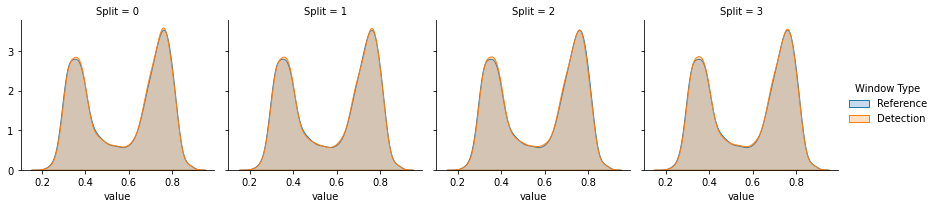

<IPython.core.display.Javascript object>

In [29]:
plot_response_distributions_bysplit(uncertainty_ks_nodrift)

**It looks like Kologorov-Smirnov is too sensitive/strict for our use case**

"A test has told you that two samples aren't from literally identical populations, but that's not what you actually care about. What you actually care about is up to you; it sounds like you care about how different the populations are. The solution is not to try to transform 𝑝-values ("when all you have is a hammer", etc.) but to use a more appropriate technique."

Even with the non-drifting dataset and huge windows, KS tests are too sensitive.

### Distance Metrics instead of KS test?

Maybe we could try calculating a distance instead of applying a check yes-no hypothesis test. The drawback here is that using distances requires us to then tune a threshold that indicates what level of distance is deemed acceptable - another hyperparameter to tune

In [30]:
calculate_split_window_distances(sqsi_mr, scipy.stats.entropy)

NameError: name 'sqsi_mr' is not defined

<IPython.core.display.Javascript object>

In [31]:
calculate_distances_window_distances(sqsi_mr, scipy.stats.wasserstein_distance)

NameError: name 'calculate_distances_window_distances' is not defined

<IPython.core.display.Javascript object>

In [32]:
calculate_distances_window_distances(sqsi_mr, scipy.spatial.distance.jensenshannon)

NameError: name 'calculate_distances_window_distances' is not defined

<IPython.core.display.Javascript object>

## Margin Uncertainty Approach with Chi-Squared Test

In [33]:
CT_nodrift_dataset = Dataset(
    full_df=nodrift_df, column_mapping=column_mapping, window_size=17500 * 3
)

uncertainty_x2_nodrift = UncertaintyX2Experiment(
    model=model,
    dataset=CT_nodrift_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2_nodrift.run()

Dataset index of split end: 105000
GETTING REFERENCE DISTRIBUTION FOR WINDOW: 0
SELF MODEL: RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)
GETTING DETECTION DISTRIBUTION FOR WINDOW: 1
X2 Test Result: PASSED | Power_divergenceResult(statistic=5.470981722724418, pvalue=0.019334761709699173)

Dataset index of split end: 157500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 2
X2 Test Result: PASSED | Power_divergenceResult(statistic=3.591452171436281, pvalue=0.05807747157488119)

Dataset index of split end: 210000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 3
X2 Test Result: PASSED | Power_divergenceResult(statistic=8.424070104253593, pvalue=0.003702859703587997)

Dataset index of split end: 262500
GETTING DETECTION DISTRIBUTION FOR WINDOW: 4
X2 Test Result: PASSED | Power_divergenceResult(statistic=0.3990502412706979, pvalue=0.5275801598106579)

Dataset index of split end: 315000
GETTING DETECTION DISTRIBUTION FOR WINDOW: 5
X2 Test Result: FAILED | Power_divergenceResu

<IPython.core.display.Javascript object>

In [28]:
plot_margin_distributions_bysplit(uncertainty_x2_nodrift)

NameError: name 'uncertainty_x2_nodrift' is not defined

<IPython.core.display.Javascript object>

- Null Hypothesis (H0): Observed data follow the expected distribution
- Alternative Hypothesis (HA): Observed data do NOT follow the expected distribution
    
If p_value is less than 0.05, reject null hypothesis --> They are from different distributions